In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
df = pd.read_csv('/content/emotion_sentimen_dataset.csv')
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [3]:
df.isnull().sum()

,0
Unnamed: 0,0
text,0
Emotion,1


In [5]:
modus = df['Emotion'].mode()[0]
df['Emotion'] = df['Emotion'].fillna(modus)
df.isna().sum()

,0
Unnamed: 0,0
text,0
Emotion,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84443 entries, 0 to 84442
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  84443 non-null  int64 
 1   text        84443 non-null  object
 2   Emotion     84443 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [7]:
df['Emotion'].value_counts()

,count
Emotion,
neutral,68090
love,3758
happiness,2776
sadness,1703
relief,1634
hate,1575
anger,1296
fun,954
enthusiasm,920


In [8]:
def getSubjectivity(text):
  objek = TextBlob(text)
  level = objek.sentiment.polarity

  if level > 0:
    result = "Positive"
  elif level < 0:
    result = "Negative"
  else:
    result = "Neutral"
  return result

getSubjectivity("i'm feel nothing")

'Neutral'

In [9]:
df['Sentimen'] = df['text'].apply(getSubjectivity)
df.head(10)

,Unnamed: 0,text,Emotion,Sentimen
0,0,i seriously hate one subject to death but now ...,hate,Negative
1,1,im so full of life i feel appalled,neutral,Negative
2,2,i sit here to write i start to dig out my feel...,neutral,Negative
3,3,ive been really angry with r and i feel like a...,anger,Negative
4,4,i feel suspicious if there is no one outside l...,neutral,Neutral
5,5,i feel jealous becasue i wanted that kind of l...,love,Positive
6,6,when a friend of mine keeps telling me morbid ...,neutral,Neutral
7,7,i finally fell asleep feeling angry useless an...,worry,Negative
8,8,i feel a bit annoyed and antsy in a good way,neutral,Positive
9,9,i feel like i ve regained another vital part o...,neutral,Positive


In [10]:
# cek karakter atau puntuation text
df['text']

,text
0,i seriously hate one subject to death but now ...
1,im so full of life i feel appalled
2,i sit here to write i start to dig out my feel...
3,ive been really angry with r and i feel like a...
4,i feel suspicious if there is no one outside l...
...,...
84438,i am sure that in the cold night air my indeli...
84439,i then repeat to myself again i feel terrific
84440,i feel angry and hurt and eternally sad
84441,i hate struggling to enjoy life but at the sam...


In [11]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
84438,False
84439,False
84440,False
84441,False


In [12]:
## cleaning text
import string

def clean_text(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Menghapus URL
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Menghapus angka
    text = re.sub(r'\d+', '', text)
    # Menghapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Menghapus spasi tambahan
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

In [13]:
# membuat fitur dan label
X_feature = df['text']
y_label = df['Sentimen']

In [14]:
# Tokenisasi teks
# Dikurangi, awalnya 10.000
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_feature)

# Mengubah teks menjadi urutan angka
X_seq = tokenizer.texts_to_sequences(X_feature)

# Padding untuk membuat panjang teks seragam
max_length = 100
X_padded = pad_sequences(X_seq, maxlen=max_length, padding='post', truncating='post')

# Pastikan label dikonversi ke one-hot encoding
y_onehot = pd.get_dummies(y_label).values

In [15]:
x_train,x_test,y_train,y_test = train_test_split(X_padded, y_onehot, test_size=0.3,random_state=42)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_length),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the optimized model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 98, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 327,299 (1.25 MB)

 Trainable params: 327,299 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.95):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")

        if acc >= self.target_accuracy:
            print(f"\nEpoch {epoch+1}: Target accuracy reached. Stopping training.")
            self.model.stop_training = True

early_stopping = StopAtAccuracy(target_accuracy=0.95)

In [29]:
# Melatih model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5
)

Epoch 1/5
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9738 - loss: 0.0744 - val_accuracy: 0.9488 - val_loss: 0.2050
Epoch 2/5
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9800 - loss: 0.0603 - val_accuracy: 0.9452 - val_loss: 0.2023
Epoch 3/5
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9819 - loss: 0.0518 - val_accuracy: 0.9477 - val_loss: 0.2461
Epoch 4/5
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9850 - loss: 0.0438 - val_accuracy: 0.9427 - val_loss: 0.2765
Epoch 5/5
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9876 - loss: 0.0383 - val_accuracy: 0.9406 - val_loss: 0.2583


In [30]:
# Evaluasi model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9402 - loss: 0.2532
Loss: 0.25828561186790466, Accuracy: 0.9406307935714722


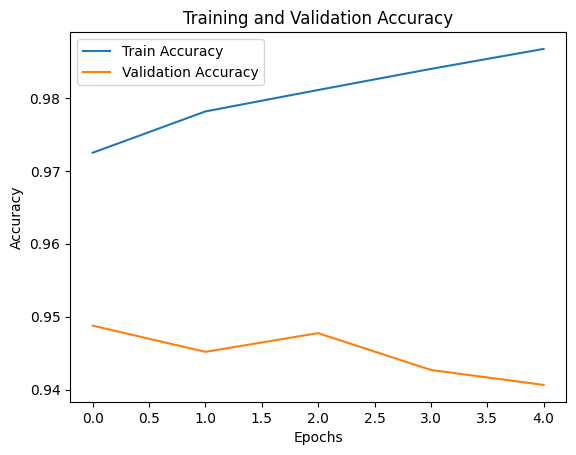

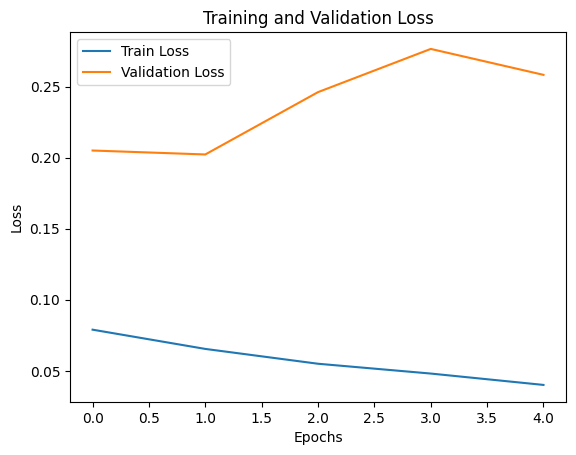

In [31]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [37]:
# Prediksi dengan data baru
test_texts = ["I love this!", "This is awful.", "It's neutral."]
test_texts_seq = tokenizer.texts_to_sequences(test_texts)
test_texts_padded = pad_sequences(test_texts_seq, maxlen=max_length, padding='post')

predictions = model.predict(test_texts_padded)
predicted_classes = tf.argmax(predictions, axis=1).numpy()

for text, sentiment in zip(test_texts, predicted_classes):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {['Negative', 'Neutral', 'Positive'][sentiment]}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Text: I love this!
Predicted Sentiment: Positive

Text: This is awful.
Predicted Sentiment: Negative

Text: It's neutral.
Predicted Sentiment: Neutral



In [38]:
# Save the model in the Keras format (.keras)
model.save('model.keras')

In [39]:
# Load the saved model
model = tf.keras.models.load_model('/content/model.keras')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the inference type to float32 (the default type for TFLite)
converter.target_spec.supported_types = [tf.float32]

# Convert the model to TFLite format
tflite_model = converter.convert()

# Save the TFLite model to a .tflite file
with open('emotion_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp1z5k_r2t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.int32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137376283119808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137376283116112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137376283694656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137376283703280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137376283703984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137376281745312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137376281746192: TensorSpec(shape=(), dtype=tf.resource, name=None)
